# Relation between protein embeddings

Protein embeddings are computed by averaging over the embeddings of all the domains in a protein



## Importing Modules

In [52]:
import pickle
import numpy as np
from tqdm import tqdm
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.spatial import distance
from math import log2 

import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'DomainPFP')))

from domaingo_embedding_model import DomainGOEmbeddingModel, load_domaingo_embedding_model_weights
from domain_embedding import DomainEmbedding
from data_processing import compute_domain_go_intersection, compute_domain_go_score
from utils import Ontology

## Load data

In [3]:
all_protein_domains_bp = pickle.load(open('../data/processed/all_protein_domains_swissprot_bp.p','rb'))
all_protein_domains_mf = pickle.load(open('../data/processed/all_protein_domains_swissprot_mf.p','rb'))
all_protein_domains_cc = pickle.load(open('../data/processed/all_protein_domains_swissprot_cc.p','rb'))

all_protein_gos_bp = pickle.load(open('../data/processed/all_protein_gos_swissprot_bp.p','rb'))
all_protein_gos_mf = pickle.load(open('../data/processed/all_protein_gos_swissprot_mf.p','rb'))
all_protein_gos_cc = pickle.load(open('../data/processed/all_protein_gos_swissprot_cc.p','rb'))

all_go_proteins_bp = pickle.load(open('../data/processed/all_go_proteins_swissprot_bp.p','rb'))
all_go_proteins_mf = pickle.load(open('../data/processed/all_go_proteins_swissprot_mf.p','rb'))
all_go_proteins_cc = pickle.load(open('../data/processed/all_go_proteins_swissprot_cc.p','rb'))

domain_mapper_bp = pickle.load(open('../data/processed/domain_mapper_swissprot_bp.p','rb'))
domain_mapper_mf = pickle.load(open('../data/processed/domain_mapper_swissprot_mf.p','rb'))
domain_mapper_cc = pickle.load(open('../data/processed/domain_mapper_swissprot_cc.p','rb'))

go_mapper_bp = pickle.load(open('../data/processed/go_mapper_swissprot_bp.p','rb'))
go_mapper_mf = pickle.load(open('../data/processed/go_mapper_swissprot_mf.p','rb'))
go_mapper_cc = pickle.load(open('../data/processed/go_mapper_swissprot_cc.p','rb'))

In [42]:
# filter the proteins that has MFO, BPO and CCO labels

proteins = []

for prtn in list(set(all_protein_domains_mf).intersection(set(all_protein_domains_bp)).intersection(set(all_protein_domains_cc))):

    if ((len(all_protein_domains_mf[prtn])>0) and
        (len(all_protein_domains_bp[prtn])>0) and
        (len(all_protein_domains_cc[prtn])>0)):

            proteins.append(prtn)

proteins.sort()


## Create random protein pairs

In [48]:
def create_prtn_pairs(list_prtns,rand_count):
    """
    Creates random pairs of proteins

    Args:
        list_prtns (list): list of all the proteins
        rand_count (int): number of random pairs

    Returns:
        list(list): list of list of size (rand_count x 2), containing protein pairs
    """
    np.random.seed(2)
    
    prtn_pairs = []

    rand_prtns1 = np.random.choice(list_prtns,rand_count*2)         # generating two times random samples to avoid repeatation
    rand_prtns2 = np.random.choice(list_prtns,rand_count*2)

    ptr = 0                      # pointer of random proteins

    for i in tqdm(range(rand_count)):

        while True:
            
            prtn1 = rand_prtns1[ptr]
            prtn2 = rand_prtns2[ptr]

            if prtn1==prtn2:                                # repeated entry
                ptr+=1
                continue

            else:
                ptr+=1
                break
        
        prtn_pairs.append([prtn1,prtn2])                # new protein pair

    return prtn_pairs

In [53]:
# create 1 million protein pairs

prtn_pairs_1000000 = create_prtn_pairs(proteins, 1000000)

pickle.dump(prtn_pairs_1000000, open('../data/processed/prtn_pairs_1000000.p','wb'))

100%|██████████| 1000000/1000000 [00:04<00:00, 204101.45it/s]


In [6]:
# or load already created ones

prtn_pairs_1000000 = pickle.load(open('../data/processed/prtn_pairs_1000000.p','rb'))

## Load domain embeddings

In [10]:
mdl_mf = DomainGOEmbeddingModel(domain_mapper_mf, go_mapper_mf)                             # create a model
mdl_mf = load_domaingo_embedding_model_weights(mdl_mf, '../saved_models/swissprot_mf')      # load model weights
dmn_embedding_mf = DomainEmbedding(mdl_mf, domain_mapper_mf)                           # domain embedding object

mdl_bp = DomainGOEmbeddingModel(domain_mapper_bp, go_mapper_bp)                             # create a model
mdl_bp = load_domaingo_embedding_model_weights(mdl_bp, '../saved_models/swissprot_bp')      # load model weights
dmn_embedding_bp = DomainEmbedding(mdl_bp, domain_mapper_bp)                           # domain embedding object

mdl_cc = DomainGOEmbeddingModel(domain_mapper_cc, go_mapper_cc)                             # create a model
mdl_cc = load_domaingo_embedding_model_weights(mdl_cc, '../saved_models/swissprot_cc')      # load model weights
dmn_embedding_cc = DomainEmbedding(mdl_cc, domain_mapper_cc)                           # domain embedding object

## Compute Embedding Distance

In [12]:
def compute_embedding_distance(prtn_pairs):
    """
    Computes distances between all protein pairs in the embedding space
    Manhattan distance is used as it is more meaningful in high dimension

    Args:
        prtn_pairs (list(list)) : list of list of size (rand_count x 2), containing protein pairs

    Returns:
        list : distance in the embedding space between the protein pairs in prtn_pairs
    """

    dist_emb_prtns = []
    
    for i in tqdm(range(len(prtn_pairs))):
        
                                                    # take the proteins
        prtn1 = prtn_pairs[i][0]
        prtn2 = prtn_pairs[i][1]

                                                    # initialize embeddings        
        prtn_emb1_mf = dmn_embedding_mf.get_embedding(-1)
        prtn_emb2_mf = dmn_embedding_mf.get_embedding(-1)
        prtn_emb1_bp = dmn_embedding_bp.get_embedding(-1)
        prtn_emb2_bp = dmn_embedding_bp.get_embedding(-1)
        prtn_emb1_cc = dmn_embedding_cc.get_embedding(-1)
        prtn_emb2_cc = dmn_embedding_cc.get_embedding(-1)

                                                    # compute embeddings of domains in the proteins and add them
        for dmn1 in all_protein_domains_mf[prtn1]:
            prtn_emb1_mf += dmn_embedding_mf.get_embedding(domain_mapper_mf[dmn1])
        for dmn2 in all_protein_domains_mf[prtn2]:
            prtn_emb2_mf += dmn_embedding_mf.get_embedding(domain_mapper_mf[dmn2])
        for dmn1 in all_protein_domains_bp[prtn1]:
            prtn_emb1_bp += dmn_embedding_bp.get_embedding(domain_mapper_bp[dmn1])
        for dmn2 in all_protein_domains_bp[prtn2]:
            prtn_emb2_bp += dmn_embedding_bp.get_embedding(domain_mapper_bp[dmn2])
        for dmn1 in all_protein_domains_cc[prtn1]:
            prtn_emb1_cc += dmn_embedding_cc.get_embedding(domain_mapper_cc[dmn1])
        for dmn2 in all_protein_domains_cc[prtn2]:
            prtn_emb2_cc += dmn_embedding_cc.get_embedding(domain_mapper_cc[dmn2])

                                                    # compute the mean as protein embedding
        prtn_emb1_mf /= len(all_protein_domains_mf[prtn1])
        prtn_emb2_mf /= len(all_protein_domains_mf[prtn2])
        prtn_emb1_bp /= len(all_protein_domains_bp[prtn1])
        prtn_emb2_bp /= len(all_protein_domains_bp[prtn2])
        prtn_emb1_cc /= len(all_protein_domains_cc[prtn1])
        prtn_emb2_cc /= len(all_protein_domains_cc[prtn2])

                                                    # compute manhattan distances
        dist_emb_mf = distance.cityblock(prtn_emb1_mf,prtn_emb2_mf)
        dist_emb_bp = distance.cityblock(prtn_emb1_bp,prtn_emb2_bp)
        dist_emb_cc = distance.cityblock(prtn_emb1_cc,prtn_emb2_cc)

        dist_emb_prtn = (dist_emb_mf + dist_emb_bp + dist_emb_cc)           # compute overall manhattan distances for proteins
                                                                            # as manhattan distances along dimensions can be just added

        dist_emb_prtns.append(dist_emb_prtn)

    dist_emb_prtns = np.array(dist_emb_prtns)

    return dist_emb_prtns

In [13]:
dist_emb_prtns = compute_embedding_distance(prtn_pairs_1000000)

100%|██████████| 1000000/1000000 [01:54<00:00, 8703.95it/s]


## Compute FunSim Score

In [11]:
## Load the ontology tree

onto_tree = Ontology(f'../data/go.obo', with_rels=False) 

In [ ]:
# compute rel scores
rel_scores = {}                         # A global variable to memoize rel score computation


def compute_rel_score(go1,go2):
    """
    Computes the Relevance semantic similarity score

    Args:
        go1 (str): 1st GO term
        go2 (str): 2nd Go term

    Returns:
        float: rel score
    """

    if(f'{go1}-{go2}' in rel_scores):               # already computed
        return rel_scores[f'{go1}-{go2}']

    anc1 = onto_tree.get_anchestors(go1)
    anc2 = onto_tree.get_anchestors(go2)

    anc_cmn = anc1.intersection(anc2)           # common ancestors

    if(len(anc_cmn)==0):                    # no common ancestors
        return 0

    rel    = -1000000

    for anc in anc_cmn:                     # compute the rel score

        if anc in go_mapper_mf:
            rel = max(rel, 
                        2*log2(len(all_go_proteins_mf[anc])/len(all_protein_gos_mf))*
                        (1-(len(all_go_proteins_mf[anc])/len(all_protein_gos_mf)))/
                        (log2(len(all_go_proteins_mf[go1])/len(all_protein_gos_mf))+log2(len(all_go_proteins_mf[go2])/len(all_protein_gos_mf)))
                    )

        elif anc in go_mapper_bp:            
            rel = max(rel, 
                        2*log2(len(all_go_proteins_bp[anc])/len(all_protein_gos_bp))*
                        (1-(len(all_go_proteins_bp[anc])/len(all_protein_gos_bp)))/
                        (log2(len(all_go_proteins_bp[go1])/len(all_protein_gos_bp))+log2(len(all_go_proteins_bp[go2])/len(all_protein_gos_bp)))
                    )

        elif anc in go_mapper_cc:
            rel = max(rel, 
                        2*log2(len(all_go_proteins_cc[anc])/len(all_protein_gos_cc))*
                        (1-(len(all_go_proteins_cc[anc])/len(all_protein_gos_cc)))/
                        (log2(len(all_go_proteins_cc[go1])/len(all_protein_gos_cc))+log2(len(all_go_proteins_cc[go2])/len(all_protein_gos_cc)))
                    )

    if rel==-1000000:
        rel = 0
        
    rel_scores[f'{go1}-{go2}'] = rel
    rel_scores[f'{go2}-{go1}'] = rel

    return rel

def compute_go_score(prtn1 ,prtn2, all_protein_gos):
    """
    Compute GO score between two proteins using Rel similarity

    Args:
        prtn1 (str): name of the 1st protein
        prtn2 (str): name of the 2nd protein
        all_protein_gos (dict): python dictionary containing the GO terms of each of the proteins

    Returns:
        float: GO score
    """

    go_set1 = list(all_protein_gos[prtn1])
    go_set2 = list(all_protein_gos[prtn2])

    go_set1.sort()
    go_set2.sort()

    S_mat_rel = np.zeros((len(go_set1),len(go_set2)))

    
    for i in range(len(go_set1)):
        for j in range(len(go_set2)):

            go1 = go_set1[i]
            go2 = go_set2[j]

            rel = compute_rel_score(go1,go2)

            S_mat_rel[i][j] = rel

    
    part1_rel = 0
    part2_rel = 0

    for i in range(len(go_set1)):
        part1_rel += np.max(S_mat_rel[i,:])

    for j in range(len(go_set2)):
        part2_rel += np.max(S_mat_rel[:,j])


    rel_goscore = max(part1_rel/len(go_set1),part2_rel/len(go_set2))


    return rel_goscore


def compute_funsim_scores(prtn_pairs):
    """
    Computes funsim scores between all protein pairs in the embedding space

    Args:
        prtn_pairs (list(list)) : list of list of size (rand_count x 2), containing protein pairs

    Returns:
        list : funsim scores between the protein pairs in prtn_pairs
    """

    go_scores_mf = []
    go_scores_bp = []
    go_scores_cc = []
    
    for i in tqdm(range(len(prtn_pairs))):
        
                                                    # take the proteins
        prtn1 = prtn_pairs[i][0]
        prtn2 = prtn_pairs[i][1]

        go_scores_mf.append(compute_go_score(prtn1 ,prtn2, all_protein_gos_mf))
        go_scores_bp.append(compute_go_score(prtn1 ,prtn2, all_protein_gos_bp))
        go_scores_cc.append(compute_go_score(prtn1 ,prtn2, all_protein_gos_cc))

    go_scores_mf = np.array(go_scores_mf)
    go_scores_bp = np.array(go_scores_bp)
    go_scores_cc = np.array(go_scores_cc)

    funsim_scores = (1/3)*( (go_scores_mf/np.max(go_scores_mf))**2 + (go_scores_bp/np.max(go_scores_bp))**2 + (go_scores_cc/np.max(go_scores_cc))**2)


    return funsim_scores
    

In [21]:
funsim_scores = compute_funsim_scores(prtn_pairs_1000000)

100%|██████████| 1000000/1000000 [45:00<00:00, 370.36it/s] 


In [97]:
def plot_funsim_vs_distance(dist_emb_prtns,funsim_scores,max_dist=25,protein_count_hist_bins=None):
    """
    Plots the mean funsim score against protein embedding distance

    Args:
        dist_emb_prtns (list or numpy array): manhattan distance between pairs of protein embeddings
        funsim_scores (list or numpy array): funsim scores between pairs of protein
        max_dist (int, optional): protein distance cut-off, all the protein pairs further away from this distance are binned together.
                                  Defaults to 25.
        protein_count_hist_bins (list or numpy array, optional): histogram of protein count for color grouping. Defaults to None.
    """

    protein_dist_bins = {}                          # binning funsim score based on protein distance

    for i in range(len(dist_emb_prtns)):

        dist_round = min(round(dist_emb_prtns[i]),max_dist)

        if dist_round not in protein_dist_bins:
            protein_dist_bins[dist_round] = []

        protein_dist_bins[dist_round].append(funsim_scores[i])

                                                # create histogram of protein count if not provided
    if protein_count_hist_bins is None:
        protein_counts = [len(protein_dist_bins[dist_round]) for dist_round in protein_dist_bins]
        protein_counts.sort()
        protein_count_hist_bins = [protein_counts[len(protein_counts)*i//10] for i in range(9)] + [protein_counts[-1]+1]

    hue_order = []                          # grouping proteins based on color
    for i in range(1,len(protein_count_hist_bins)):
        hue_order.append(f'{protein_count_hist_bins[i-1]+1}-{protein_count_hist_bins[i]}')

    summary_df = []                         # summary of the funsim score vs distance

    for dist_round in protein_dist_bins:
            summary_df.append([dist_round,
                               np.mean(protein_dist_bins[dist_round]),
                               np.std(protein_dist_bins[dist_round]),
                               hue_order[np.digitize(len(protein_dist_bins[dist_round]),protein_count_hist_bins)-1]
                               ])
            
    summary_df = pd.DataFrame(summary_df,columns=['Protein Distance','Mean funSim Score','Std. funSim Score','Count'])
    plt.figure(figsize=(10,5),dpi=600);

    ax = sns.scatterplot(data=summary_df,x='Protein Distance',y='Mean funSim Score',hue='Count',size='Std. funSim Score',sizes=(20, 200),palette='magma_r',hue_order=hue_order);
    
    xtick_lbls = [item.get_text() for item in ax.get_xticklabels()]             # modifying the last xtick label
    xtick_lbls[-2] = '>'+str(xtick_lbls[-2])
    ax.set_xticklabels(xtick_lbls)
    ax.legend(bbox_to_anchor=(1.01, 0.95))
    
    plt.show()
    

/tmp/ipykernel_4043357/2584415620.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_lbls)


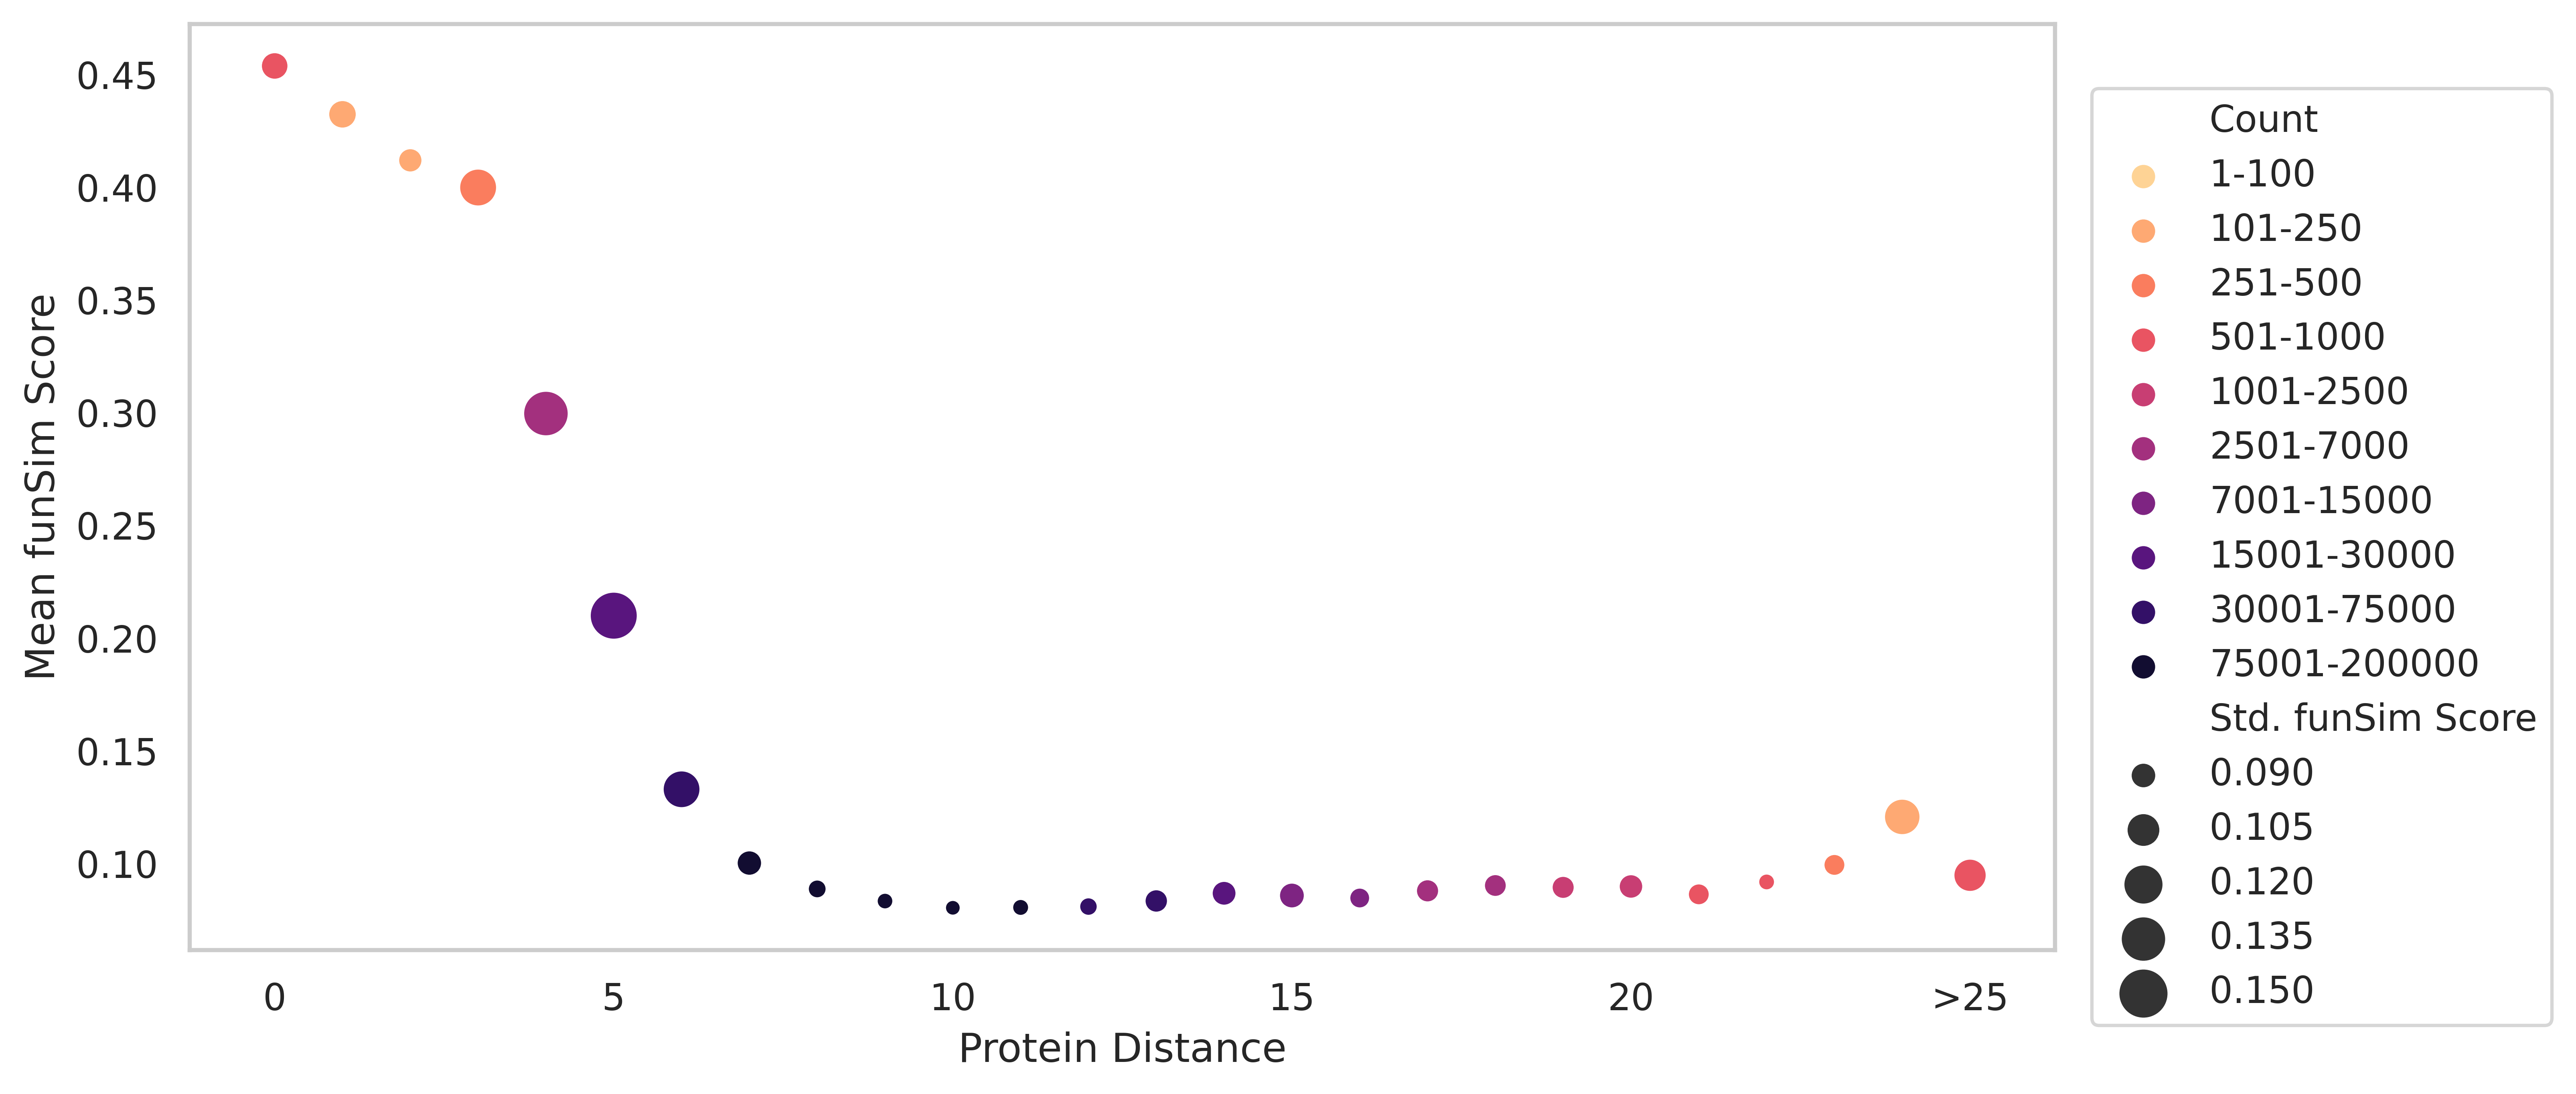

In [98]:
plot_funsim_vs_distance(dist_emb_prtns,
                        funsim_scores,
                        max_dist=25,
                        protein_count_hist_bins=[0,100,250,500,1000,2500,7000,15000,30000,75000,200000])